In [31]:
import numpy as np

a1 = np.asarray([1,2,3])
print(sys.getsizeof(a1))
a2 = np.asarray([1,2,3,4])
print(sys.getsizeof(a2))


120
128


In [32]:
((800000000*8 + 150) * 3) / (1024**3)

17.881393851712346

In [4]:
import sys
sys.path.append('../')
import pickle
from scipy.io import mmread
from collections import Counter

from utils import remove_alphabet_number_comb
from utils import read_list
from utils import make_bow
from subword_df_handler import classify_documents
from subword_df_handler import select_specific_words

%matplotlib inline
import matplotlib.pyplot as plt


model_directory = 'YOUR-MODEL-DIRECTORY'

index2category = read_list('./car_index.txt')
with open('{}/common_words.pkl'.format(model_directory), 'rb') as f:
    common_words = pickle.load(f)
with open('{}/category_sensitive_words.pkl'.format(model_directory), 'rb') as f:
    category_sensitive_words = pickle.load(f)
with open('{}/subword_df_slot.pkl'.format(model_directory), 'rb') as f:
    params = pickle.load(f)
    index2subword = params['index2subword']
    subword2index = {subword:index for index,subword in enumerate(index2subword)}
    del params
    
print(common_words['차량']) # (nstd, mean, max/mean, argmax_c)

(0.1886, 0.54053, 1.3066, 20)


In [5]:
for c, words in enumerate(category_sensitive_words):
    print(c, len(words))

0 5499
1 1773
2 1039
3 3934
4 3916
5 4271
6 479
7 273
8 762
9 2405
10 1742
11 323
12 305
13 262
14 400
15 186
16 678
17 631
18 520
19 407
20 371
21 1234
22 534
23 629
24 2326
25 2536
26 3575


In [28]:
c = 21
with open('{}/related_words_c{}.pkl'.format(model_directory, c), 'rb') as f:
    W_ij = pickle.load(f)

In [29]:
sensitive_words = set(remove_alphabet_number_comb(category_sensitive_words[c]))
common_words = set(remove_alphabet_number_comb(common_words))
true_specific, false_specific, has_no_relateds = select_specific_words(W_ij, sensitive_words, common_words, cost_factor=1.0, cutoff=0.00)

In [30]:
print('category = {}'.format(index2category[c]))
print('True specific')
print(remove_alphabet_number_comb([word for word, _ in true_specific]))
print('\nFalse specific (common words)')
print(remove_alphabet_number_comb([word for word, _ in false_specific]))
print('\nHas no related words')
print(remove_alphabet_number_comb([word for word, _ in has_no_relateds]))

category = 티볼리
True specific
['로마', '궁전', '조식', '베네치아', '아말', '바티', '오페라', '마리아', '코르', '피렌체', '루이', '덴마크', '메디', '보르', '바티칸', '포르투', '나폴', '바로크', '17세', '헝가리', '별장', '알렉산', '안토', '예술가', '폼페이', '피오', '로마에', '나폴리', '19세기', '18세기', '17세기', '팰리스', '16세기', '미켈', '수도원', '왕궁', '리조트', '세인트', '미켈란', '트레비', '알렉산드', '미켈란젤로', '미켈란젤', '사르', '베로', '예배당', '시청사', '조각상', '로마에서', '팔레', '로마시', '노동자', '코펜하겐', '동상이', '코펜', '크리스티', '놀이공원', '죽음에', '티볼리에', '베드로', '궁전에', '라파엘', '로지', '바실리', '콘스탄', '체크인', '아말피', '콜로세움', '볼로', '브뤼', '프라하', '콘도', '군주', '비잔', '볼로냐', '투르', '마르티', '파르', '도르', '장엄', '대주교', '북유럽', '율리', '암스테르담', '젤라', '색채', '그리스도교', '추기경', '총독', '신으', '신을', '세계문화', '투르크', '프란체스', '선출되', '로마시대', '19세기에', '휴양지', '도나우', '중앙역', '에우', '묘사한', '세계문화유산', '원주민', '한화', '로마인', '파스타', '비극적', '노동자들', '종교적', '세속', '베니스', '막시', '호스텔', '예루살렘', '탄압하', '로사', '메소', '오르비에', '카롤', '브뤼셀', '아르카', '루브르', '헬싱', '알반', '로마제국', '젤라또', '중엽', '살레르노', '바르셀로나', '영웅적', '라파엘로', '무화', '아를', '파라다이스', '문학과', '제자들', '시칠리아', '푸에', '피나코', 

In [15]:
positive_features = {word for word in common_words}
positive_features.update([word for word, _ in false_specific])
negative_features = {word for word, _ in true_specific}
negative_features.update([word for word, _ in has_no_relateds])

positive_features = {subword2index[word] for word in positive_features}
negative_features = {subword2index[word] for word in negative_features}

x_fname = '{}/subword_tf_c{}.mtx'.format(model_directory, c)
x = mmread(x_fname).tocsr()

In [16]:
scores, num_features, unknown_features = classify_documents(x, positive_features, negative_features, negative_score_factor=1)

classification was done.                                                  


In [17]:
print('len scores =',len(scores))
print('len counter(scores) =',len(Counter(scores)))

len scores = 229253
len counter(scores) = 32293


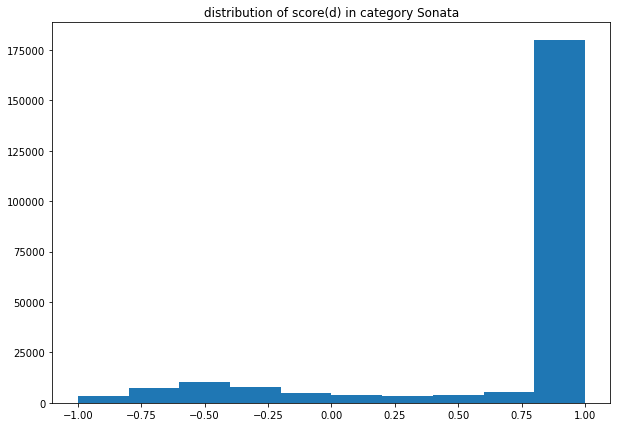

In [18]:
plt.figure(figsize=(10,7))
plt.hist(scores, bins=10)
plt.title('distribution of score(d) in category Sonata')
plt.show()

In [19]:
threshold = 0.8
negative = [i for i, score in enumerate(scores) if score < threshold]
positive = [i for i, score in enumerate(scores) if score > threshold]
print(len(negative), len(positive))

49526 179727


In [20]:
scores[15]

-0.52738139938975048

In [24]:
_counter = 0
for doc in negative:
# for doc in positive:
    bow = make_bow(doc, x, index2subword)
    if not bow:
        continue
    print('#doc={}, score={:.4}, unknown_features={:.4}, num_features={}'.format(doc, float(scores[doc]), float(unknown_features[doc]), num_features[doc]))
    print(bow, '\n')
    _counter += 1
    if _counter > 100: break

#doc=1, score=-0.4275, unknown_features=0.302, num_features=510
[('음악', 10), ('드보르자크', 9), ('연주', 8), ('미국', 7), ('4악장', 5), ('이런', 5), ('것은', 4), ('신세', 4), ('신세계', 4), ('연주하', 4), ('음악원', 4), ('있다', 4), ('주제', 4), ('학교', 4), ('1주', 3), ('1주제', 3), ('박진', 3), ('사실', 3), ('아니', 3), ('연주하는', 3), ('이라', 3), ('자리', 3), ('작곡', 3), ('저희', 3), ('조건', 3), ('초등', 3), ('초등학', 3), ('1악장', 2), ('3악장', 2), ('같아', 2)] 

#doc=8, score=0.6845, unknown_features=0.1877, num_features=405
[('감사', 31), ('감사드립니다', 31), ('해주', 27), ('해주셔', 25), ('있게', 20), ('오늘', 13), ('성경', 7), ('주셔서', 6), ('산책', 5), ('마음', 4), ('가족', 3), ('공기', 3), ('날씨', 3), ('들어', 3), ('따뜻', 3), ('따뜻한', 3), ('맑은', 3), ('북한', 3), ('좋은', 3), ('즐거', 3), ('피아', 3), ('피아노', 3), ('하루', 3), ('햇살', 3), ('가니', 2), ('가족이', 2), ('기분', 2), ('누군가', 2), ('들어올', 2), ('소나타', 2)] 

#doc=9, score=-0.4221, unknown_features=0.2515, num_features=505
[('토요', 13), ('연주', 8), ('예술', 8), ('예술의', 8), ('베토벤', 7), ('신세', 7), ('신세계', 7), ('함께', 7), ('함께하', 6), ('느낌